# 1. Business Understanding

Since the first year of Mr. President Prabowo's administration, one of the key initiatives has been improving budget efficiency across all levels of government, from ministries to local administrations. In 2025, the Indonesian House of Representatives (DPR RI) approved a 40% budget reduction for the Ministry of Tourism (source: https://emedia.dpr.go.id/2025/02/14/komisi-vii-setujui-efisiensi-anggaran-kementerian-pariwisata-tahun-2025/). As a result, several sectors have been affected, including Indonesia's tourism promotion programs.

Given these conditions, policymakers and tourism stakeholders must carefully prioritise spending without compromising tourism performance. One strategic approach is to analyse which nationalities generate the highest economic value, rather than simply focusing on those contributing the largest number of visits.

I am using CRISP-DM framewrok to documenting this project as well as machine learning approach used in this case is supervised learning, as it allows the results to be described and interpreted more intuitively for most readers.

There are 2 main questions that will be addressed in this projects:
1. Which countries generate the highest economic value to Indonesia for tourism sector?
2. What factors explain why some countries contribute higher tourism value than others?

Business values:
- ✅ Government → targeted tourism strategies
- ✅ Airlines → strengthening and developing routes
- ✅ Tourism stakeholders → service adjustments (languange, habit, etc.)

Analytical approach:
* Unit of analysis: by country and by year
* Method: Descriptive & Supervised learning (regression)
* Framework: CRISP-DM
* Models: Linear Regression (baseline & interpretability), Ridge Regression, Lasso Regression, ElasticNet, Decision Tree Regressorm Random Forest Regressor, Gradient Boosting Regressor





# 2. Data Understanding

## 2.1 Load All Datasets

In [1]:
import pandas as pd

visits = pd.read_excel('/content/drive/MyDrive/Petalytix/Predicting Tourism Trend/visits.xlsx')
spending = pd.read_excel('/content/drive/MyDrive/Petalytix/Predicting Tourism Trend/spending.xlsx')
alos = pd.read_excel('/content/drive/MyDrive/Petalytix/Predicting Tourism Trend/length_of_stay.xlsx')

Remarks:
1. visits.xlsx = "Jumlah Kunjungan Wisatawan Mancanegara ke Indonesia Menurut Kebangsaan (Kunjungan)"
2. spending.xlsx = "Rata-Rata Pengeluaran Wisatawan Mancanegara per Kunjungan Menurut Negara Tempat Tinggal (US $)"
3. length_of_stay.xlsx = "Rata-Rata Lama Tinggal Wisatawan Mancanegara Menurut Kebangsaan (Hari) / **alos** (average length of stay)"

## 2.2 Initial Exploration

- Top 10 visits by country

In [2]:
year_columns = [col for col in visits.columns if str(col).isdigit() and 2006 <= int(col) <= 2024]

for col in year_columns:
    visits[col] = pd.to_numeric(visits[col], errors='coerce')

visitor_avg = visits.copy()

visitor_avg['average'] = visitor_avg[year_columns].mean(axis=1)
visits_avg_display = visitor_avg[~visitor_avg['Kebangsaan'].str.contains('TOTAL', na=False, case=False)].copy()

visits_avg_display_sorted = visits_avg_display.sort_values(by='average', ascending=False).copy().reset_index(drop=True)
pd.options.display.float_format = '{:,.0f}'.format

print("Top 10 average number of visits by Kebangsaan in Jumlah Kunjungan from 2006 to 2024 (largest to lowest)")
display(visits_avg_display_sorted[['Kebangsaan', 'average']].head(10))

Top 10 average number of visits by Kebangsaan in Jumlah Kunjungan from 2006 to 2024 (largest to lowest)


,Kebangsaan,average
0,Malaysia,"1,441,835"
1,Singapura,"1,249,063"
2,Timor Leste,"990,446"
3,Australia,"875,037"
4,Tionghoa,"871,292"
5,Jepang,"408,646"
6,India,"305,386"
7,Korea Selatan,"305,226"
8,Asean Lainnya,"252,340"
9,Amerika Serikat,"240,928"


- Top 10 spending by country

In [3]:
year_columns = [col for col in spending.columns if str(col).isdigit() and 2000 <= int(col) <= 2024]

for col in year_columns:
    spending[col] = pd.to_numeric(spending[col], errors='coerce')

spending_avg = spending.copy()

spending_avg['average'] = spending_avg[year_columns].mean(axis=1)

spending_avg_display_sorted = spending_avg.sort_values(by='average', ascending=False).copy().reset_index(drop=True)

print("Top 10 average number of spending by Negara Tempat Tinggal in US$ from 2000 to 2024 (largest to lowest)")
display(spending_avg_display_sorted[['Negara Tempat Tinggal', 'average']].head(10))

Top 10 average number of spending by Negara Tempat Tinggal in US$ from 2000 to 2024 (largest to lowest)


,Negara Tempat Tinggal,average
0,Spanyol,"1,923"
1,Portugal,"1,906"
2,Austria,"1,886"
3,Rusia,"1,849"
4,Belanda,"1,753"
5,Arab Saudi,"1,750"
6,Amerika Serikat,"1,730"
7,Perancis,"1,667"
8,Jerman,"1,635"
9,Kanada,"1,627"


- Top 10 length of stay by country

In [4]:
import numpy as np

year_columns = [col for col in alos.columns if str(col).isdigit() and 2000 <= int(col) <= 2024]

for col in year_columns:
    alos[col] = pd.to_numeric(alos[col], errors='coerce')

alos_avg = alos.copy()

alos_avg['average'] = np.round(alos_avg[year_columns].mean(axis=1), 2)

alos_avg_display_sorted = alos_avg.sort_values(by='average', ascending=False).copy().reset_index(drop=True)
alos_avg_display_sorted['average'] = alos_avg_display_sorted['average'].map('{:.2f}'.format)

print("Top 10 average length of stay by Negara Tempat Tinggal in days from 2000 to 2024 (largest to lowest)")
display(alos_avg_display_sorted[['Negara Tempat Tinggal', 'average']].head(10))

Top 10 average length of stay by Negara Tempat Tinggal in days from 2000 to 2024 (largest to lowest)


,Negara Tempat Tinggal,average
0,Rusia,19.00
1,Swiss,16.51
2,Jerman,15.60
3,Belanda,15.56
4,Belgia,15.46
5,Perancis,15.30
6,Denmark,15.08
7,Finlandia,14.73
8,Norwegia,14.63
9,Kanada,14.22


# 3. Data Preparation

## 3.1 Data Cleaning

- Origin

In [5]:
visits_origin = set(visits['Kebangsaan'].unique())
spending_origin = set(spending['Negara Tempat Tinggal'].unique())
alos_origin = set(alos['Negara Tempat Tinggal'].unique())

domicile = sorted(list(visits_origin.union(spending_origin).union(alos_origin)))
print(f"Number of unique domiciles: {len(domicile)}")
print("List of unique domiciles:")
display(domicile)

Number of unique domiciles: 69
List of unique domiciles:


['Afrika Lainnya',
 'Afrika Selatan',
 'Amerika Lainnya',
 'Amerika Selatan',
 'Amerika Serikat',
 'Amerika Tengah',
 'Arab Saudi',
 'Asean Lainnya',
 'Asia Lainnya',
 'Australia',
 'Austria',
 'Bahrain',
 'Bangladesh',
 'Belanda',
 'Belgia',
 'Brunei Darussalam',
 'Cina',
 'Denmark',
 'Eropa Barat Lainnya',
 'Eropa Timur Lainnya',
 'Eropa lainnya',
 'Filipina',
 'Finlandia',
 'GRAND TOTAL',
 'Hong Kong',
 'India',
 'Inggris',
 'Italia',
 'Jepang',
 'Jerman',
 'Kanada',
 'Korea Selatan',
 'Kuwait',
 'Malaysia',
 'Mesir',
 'Myanmar',
 'Negara lainnya',
 'Norwegia',
 'Oceania Lainnya',
 'Pakistan',
 'Papua Nugini',
 'Perancis',
 'Portugal',
 'Qatar',
 'Rata- Rata',
 'Rusia',
 'Saudi Arabia',
 'Selandia Baru',
 'Singapura',
 'Spanyol',
 'Sri Lanka',
 'Srilanka',
 'Swedia',
 'Swiss',
 'TOTAL AFRICA',
 'TOTAL AMERIKA',
 'TOTAL ASEAN',
 'TOTAL ASIA (Excl. ASEAN)',
 'TOTAL EROPA',
 'TOTAL OCEANIA',
 'TOTAL TIMUR TENGAH',
 'Taiwan',
 'Thailand',
 'Timor Leste',
 'Timur Tengah Lainnya',
 'Tiong

In [6]:
origins_to_drop = {
    'GRAND TOTAL',
    'Rata- Rata',
    'TOTAL AFRICA',
    'TOTAL AMERIKA',
    'TOTAL ASEAN',
    'TOTAL ASIA (Excl. ASEAN)',
    'TOTAL EROPA',
    'TOTAL OCEANIA',
    'TOTAL TIMUR TENGAH'
}

visits = visits[~visits['Kebangsaan'].isin(origins_to_drop)]
spending = spending[~spending['Negara Tempat Tinggal'].isin(origins_to_drop)]
alos = alos[~alos['Negara Tempat Tinggal'].isin(origins_to_drop)]

- Country Re-mapping

In [7]:
country_map = {
    # Duplicates & translations
    "Arab Saudi": "Saudi Arabia",
    "Saudi Arabia": "Saudi Arabia",
    "Sri Lanka": "Sri Lanka",
    "Srilanka": "Sri Lanka",
    "Cina": "China",
    "Tionghoa": "China",
    "Inggris": "United Kingdom",
    "Belanda": "Netherlands",
    "Perancis": "France",
    "Jerman": "Germany",
    "Amerika Serikat": "United States",
    "Korea Selatan": "South Korea",
    "Selandia Baru": "New Zealand",
    "Uni Emirat Arab": "United Arab Emirates",
    "Timor Leste": "Timor-Leste",
    "Afrika Selatan": "South Africa",
    "Jepang": "Japan",
    "Kanada": "Canada",
    "Mesir": "Egypt",
    "Norwegia": "Norway",
    "Papua Nugini": "Papua New Guinea",
    "Rusia": "Russia",
    "Singapura": "Singapore",
    "Spanyol": "Spain",
    "Swedia": "Sweden",
    "Swiss": "Switzerland",
    "Yaman": "Yemen",
    "Belgia": "Belgium",
    "Filipina": "Philippines",
    "Finlandia": "Finland",
    "Italia": "Italy",

    # Regional categories
    "Afrika Lainnya": "Africa (Other)",
    "Amerika Lainnya": "Americas (Other)",
    "Amerika Tengah": "Central America",
    "Amerika Selatan": "South America",
    "Asean Lainnya": "ASEAN (Other)",
    "Asia Lainnya": "Asia (Other)",
    "Eropa Barat Lainnya": "Western Europe (Other)",
    "Eropa Timur Lainnya": "Eastern Europe (Other)",
    "Eropa lainnya": "Europe (Other)",
    "Timur Tengah Lainnya": "Middle East (Other)",
    "Oceania Lainnya": "Oceania (Other)",
    "Negara lainnya": "Other Countries"
}

In [8]:
visits['Kebangsaan'] = visits['Kebangsaan'].replace(country_map)
spending['Negara Tempat Tinggal'] = spending['Negara Tempat Tinggal'].replace(country_map)
alos['Negara Tempat Tinggal'] = alos['Negara Tempat Tinggal'].replace(country_map)

- Melt and Reshaping

1. Melt the 'visitor', 'spending', and 'alos' DataFrame from wide to long format → converting year columns into rows.
2. Rename the 'Kebangsaan' or 'Negara Tempat Tinggal' column to 'country'
3. Four reshaped columns: ['year', 'visits', 'alos', 'spending']

In [9]:
visitor_melted = pd.melt(visits, id_vars=['Kebangsaan'], var_name='year', value_name='visits')
visitor_melted = visitor_melted.rename(columns={'Kebangsaan': 'country'})

visitor_melted.head()

,country,year,visits
0,Brunei Darussalam,2006,"11,154"
1,Malaysia,2006,"699,124"
2,Philippines,2006,"187,711"
3,Singapore,2006,"1,164,082"
4,Thailand,2006,"66,864"


In [10]:
spending_melted = pd.melt(spending, id_vars=['Negara Tempat Tinggal'], var_name='year', value_name='spending')
spending_melted = spending_melted.rename(columns={'Negara Tempat Tinggal': 'country'})

spending_melted.head()

,country,year,spending
0,Brunei Darussalam,2000,"1,027"
1,Malaysia,2000,616
2,Philippines,2000,586
3,Singapore,2000,639
4,Thailand,2000,716


In [11]:
alos_melted = pd.melt(alos, id_vars=['Negara Tempat Tinggal'], var_name='year', value_name='alos')
alos_melted = alos_melted.rename(columns={'Negara Tempat Tinggal': 'country'})
alos_melted['alos'] = alos_melted['alos'].map('{:.2f}'.format)


alos_melted.head()

,country,year,alos
0,Brunei Darussalam,2000,6.05
1,Malaysia,2000,6.54
2,Philippines,2000,5.55
3,Singapore,2000,5.44
4,Thailand,2000,6.92


In [12]:
combined_df = pd.merge(visitor_melted, spending_melted, on=['country', 'year'], how='outer')
combined_df = pd.merge(combined_df, alos_melted, on=['country', 'year'], how='outer')

display(combined_df.sample(5))
print(f"Shape of the combined tables: {combined_df.shape}")

,country,year,visits,spending,alos
928,Singapore,2002,NaN,527,5.04
988,South America,2018,"62,868","1,361",13.36
1301,Yemen,2011,"6,729",NaN,NaN
91,Australia,2015,"1,090,025","1,617",10.33
933,Singapore,2007,"1,160,200",593,5.18


Shape of the combined tables: (1315, 5)


In [13]:
for col in ['visits', 'alos', 'spending']:
    combined_df[col] = combined_df[col].replace({'-': pd.NA, ' ': pd.NA, '': pd.NA, 0: pd.NA})
    combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')

combined_df['year'] = pd.to_numeric(combined_df['year'], errors='coerce').astype(pd.Int64Dtype())
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1315 entries, 0 to 1314
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   country   1315 non-null   object 
 1   year      1315 non-null   Int64  
 2   visits    1019 non-null   float64
 3   spending  788 non-null    float64
 4   alos      876 non-null    float64
dtypes: Int64(1), float64(3), object(1)
memory usage: 52.8+ KB


In [14]:
print(f"Total country/origin of the visits: {len(combined_df['country'].unique())}")

Total country/origin of the visits: 57


## 3.2 Handling Missing Data

- Analyse

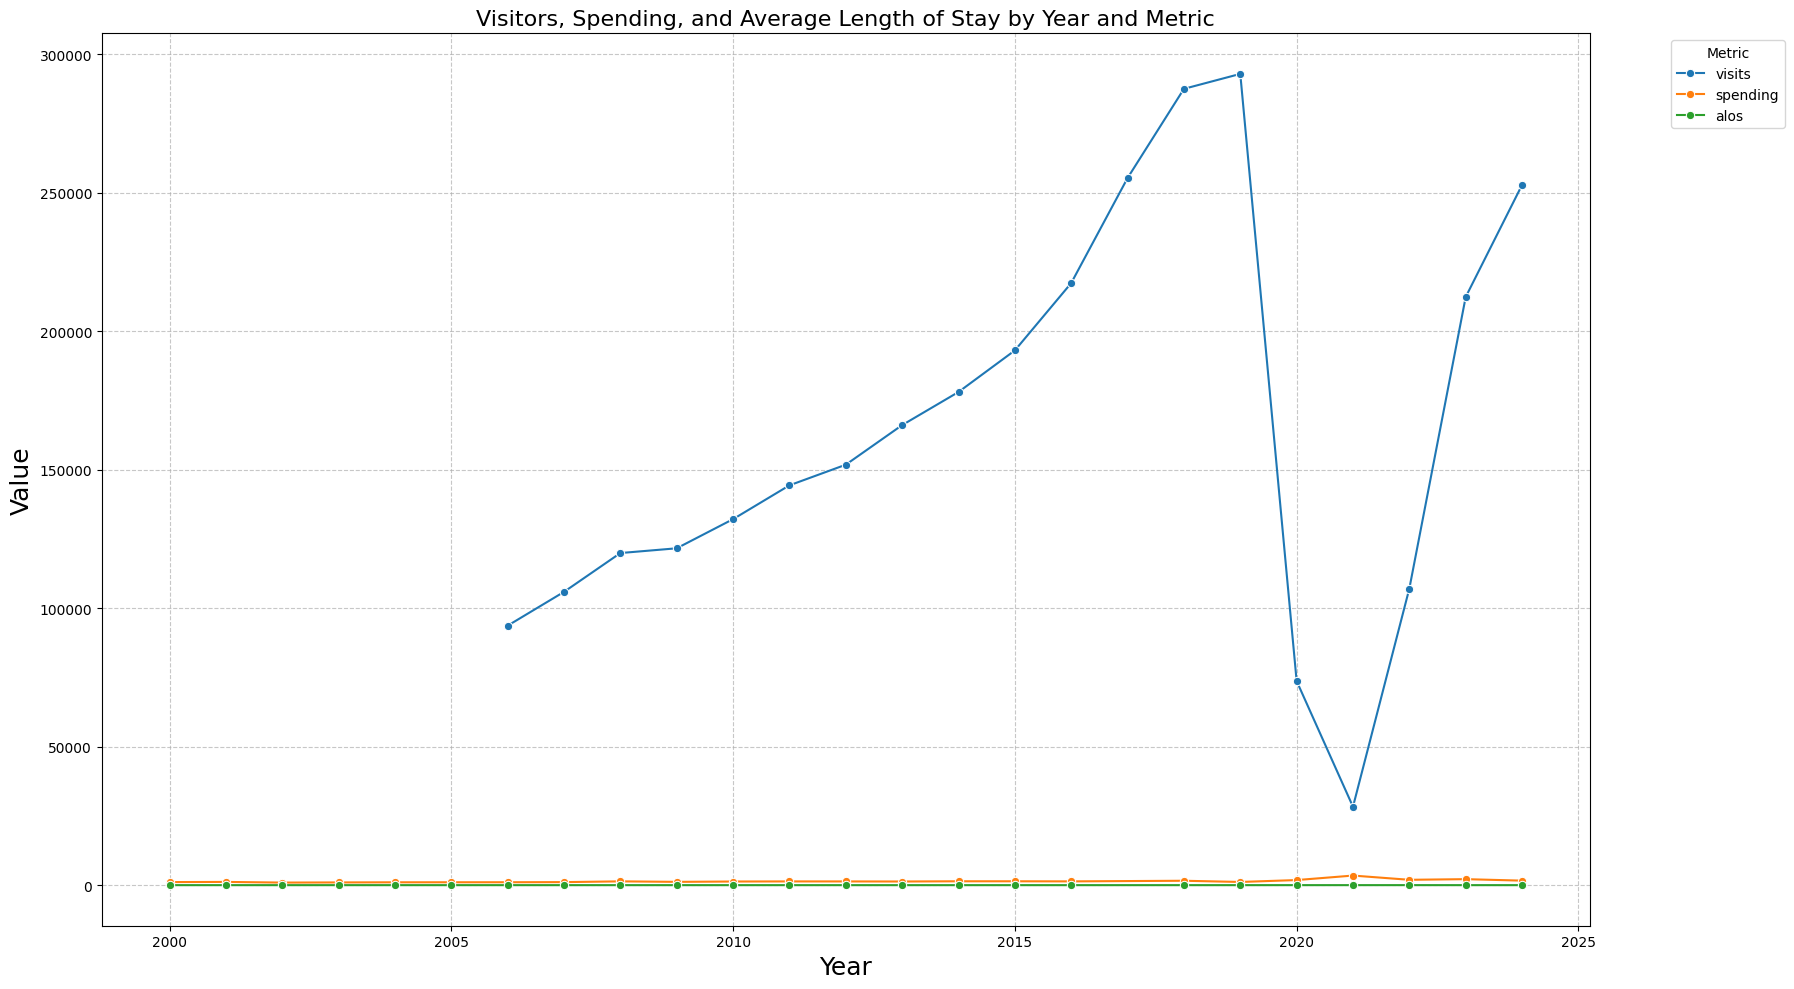

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

melted_df = combined_df.melt(id_vars=['country', 'year'],
                             value_vars=['visits', 'spending', 'alos'],
                             var_name='metric',
                             value_name='value')

filtered_melted_df = melted_df[~melted_df['country'].str.contains('TOTAL', na=False, case=False)].dropna(subset=['value']).copy()

filtered_melted_df['year'] = pd.to_numeric(filtered_melted_df['year'], errors='coerce')

plt.figure(figsize=(18, 10))

sns.lineplot(data=filtered_melted_df, x='year', y='value', hue='metric', marker='o', errorbar=None)

plt.title('Visitors, Spending, and Average Length of Stay by Year and Metric', fontsize=16)
plt.xlabel('Year', fontsize=18)
plt.ylabel('Value', fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

As seen in the chart above, there are no information about number of visits from 2000 to 2005. Since that condition, the analysis will only observe the intersection period from 2006 onward because this feature is a core and if the data is not valid it will lead to questionable decision-making later.

In addition to that, it's clear that during pandemic covid 19 (2020-2022) the number of visits dropped significantly. So that, it will be taken into consideration in the modelling later.

In [16]:
df = combined_df[combined_df['year'] >= 2006].copy()

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1081 entries, 0 to 1314
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   country   1081 non-null   object 
 1   year      1081 non-null   Int64  
 2   visits    1019 non-null   float64
 3   spending  609 non-null    float64
 4   alos      683 non-null    float64
dtypes: Int64(1), float64(3), object(1)
memory usage: 51.7+ KB


- Visitors

In [18]:
display(df[df['visits'].isna()])
print(f"List of countries with NA value: {len(df[df['visits'].isna()]['country'].unique())}")
print(f"List of countries with NA value: {df[df['visits'].isna()]['country'].unique()}")

,country,year,visits,spending,alos
38,Americas (Other),2006,NaN,NaN,NaN
39,Americas (Other),2007,NaN,NaN,NaN
40,Americas (Other),2008,NaN,NaN,NaN
41,Americas (Other),2009,NaN,NaN,NaN
370,Europe (Other),2006,NaN,NaN,NaN
...,...,...,...,...,...
1176,Timor-Leste,2012,NaN,NaN,NaN
1177,Timor-Leste,2013,NaN,NaN,NaN
1178,Timor-Leste,2014,NaN,NaN,NaN
1179,Timor-Leste,2015,NaN,NaN,NaN


List of countries with NA value: 5
List of countries with NA value: ['Americas (Other)' 'Europe (Other)' 'Other Countries' 'Papua New Guinea'
 'Timor-Leste']


1. There are ~9% (5 out of 57) countries with NA value in visits between 2006 to 2024
2. There are ~6% or 62 records with NA value in visits between 2006 to 2024




In [19]:
df[df['country'] == 'Americas (Other)']

,country,year,visits,spending,alos
38,Americas (Other),2006,NaN,NaN,NaN
39,Americas (Other),2007,NaN,NaN,NaN
40,Americas (Other),2008,NaN,NaN,NaN
41,Americas (Other),2009,NaN,NaN,NaN
42,Americas (Other),2010,"7,194",NaN,NaN
43,Americas (Other),2011,"5,735",NaN,NaN
44,Americas (Other),2012,"6,727",NaN,NaN
45,Americas (Other),2013,"7,528",NaN,NaN
46,Americas (Other),2014,"8,009",NaN,NaN
47,Americas (Other),2015,"11,882",NaN,NaN


In [20]:
df[df['country'] == 'Europe (Other)']

,country,year,visits,spending,alos
370,Europe (Other),2006,NaN,NaN,NaN
371,Europe (Other),2007,NaN,NaN,NaN
372,Europe (Other),2008,NaN,NaN,NaN
373,Europe (Other),2009,NaN,NaN,NaN
374,Europe (Other),2010,NaN,NaN,NaN
375,Europe (Other),2011,NaN,NaN,NaN
376,Europe (Other),2012,NaN,NaN,NaN
377,Europe (Other),2013,NaN,NaN,NaN
378,Europe (Other),2014,NaN,NaN,NaN
379,Europe (Other),2015,NaN,NaN,NaN


In [21]:
df[df['country'] == 'Other Countries']

,country,year,visits,spending,alos
745,Other Countries,2006,NaN,587,11
746,Other Countries,2007,NaN,"1,143",10
747,Other Countries,2008,NaN,"1,459",10
748,Other Countries,2009,NaN,"1,208",9
749,Other Countries,2010,NaN,"1,252",9
750,Other Countries,2011,NaN,"1,428",11
751,Other Countries,2012,NaN,"1,447",9
752,Other Countries,2013,NaN,"1,340",8
753,Other Countries,2014,NaN,"1,456",9
754,Other Countries,2015,NaN,"1,612",10


In [22]:
df[df['country'] == 'Papua New Guinea']

,country,year,visits,spending,alos
788,Papua New Guinea,2006,NaN,NaN,NaN
789,Papua New Guinea,2007,NaN,NaN,NaN
790,Papua New Guinea,2008,NaN,NaN,NaN
791,Papua New Guinea,2009,NaN,NaN,NaN
792,Papua New Guinea,2010,NaN,NaN,NaN
793,Papua New Guinea,2011,NaN,NaN,NaN
794,Papua New Guinea,2012,NaN,NaN,NaN
795,Papua New Guinea,2013,NaN,NaN,NaN
796,Papua New Guinea,2014,NaN,NaN,NaN
797,Papua New Guinea,2015,NaN,NaN,NaN


In [23]:
df[df['country'] == 'Timor-Leste']

,country,year,visits,spending,alos
1170,Timor-Leste,2006,NaN,NaN,NaN
1171,Timor-Leste,2007,NaN,NaN,NaN
1172,Timor-Leste,2008,NaN,NaN,NaN
1173,Timor-Leste,2009,NaN,NaN,NaN
1174,Timor-Leste,2010,NaN,NaN,NaN
1175,Timor-Leste,2011,NaN,NaN,NaN
1176,Timor-Leste,2012,NaN,NaN,NaN
1177,Timor-Leste,2013,NaN,NaN,NaN
1178,Timor-Leste,2014,NaN,NaN,NaN
1179,Timor-Leste,2015,NaN,NaN,NaN


Since there are 5 countries with major missing values and if the imputation is performed it will make a bias for the model. So, I will drop them to the modelling.

In [24]:
df_clean = df.copy()
df_clean = df_clean[~df_clean['country'].isin(['Americas (Other)', 'Europe (Other)', 'Other Countries', 'Papua New Guinea', 'Timor-Leste'])]
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 988 entries, 0 to 1314
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   country   988 non-null    object 
 1   year      988 non-null    Int64  
 2   visits    988 non-null    float64
 3   spending  591 non-null    float64
 4   alos      664 non-null    float64
dtypes: Int64(1), float64(3), object(1)
memory usage: 47.3+ KB


- Spending & Avg Length of Stay (ALOS)

> drop countries where the 'spending' and 'average length of stay' are missing for the whole period (2006 to 2024)

In [25]:
countries_all_missing = (
    df_clean
    .groupby('country')
    .filter(lambda x: x['spending'].isna().all() and x['alos'].isna().all())
)

In [26]:
countries_all_missing['country'].unique()

array(['ASEAN (Other)', 'Africa (Other)', 'Asia (Other)', 'Bahrain',
       'Eastern Europe (Other)', 'Kuwait', 'Middle East (Other)',
       'Myanmar', 'Oceania (Other)', 'Qatar', 'South Africa',
       'United Arab Emirates', 'Vietnam', 'Western Europe (Other)',
       'Yemen'], dtype=object)

In [27]:
df_clean = df_clean[~df_clean['country'].isin(countries_all_missing['country'].unique())]

> perform imputation for spending and alos

In [28]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 703 entries, 82 to 1257
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   country   703 non-null    object 
 1   year      703 non-null    Int64  
 2   visits    703 non-null    float64
 3   spending  591 non-null    float64
 4   alos      664 non-null    float64
dtypes: Int64(1), float64(3), object(1)
memory usage: 33.6+ KB


Missing values:
1. Spending: ~16% missing (112 / 703)
2. ALOS: ~5.5% missing (39 / 703)

In [29]:
print(f"Total countries with missing values in spending and/or alos: {len(df_clean[df_clean['spending'].isna()]['country'].unique())}")
display(df_clean[df_clean['spending'].isna()]['country'].unique())

Total countries with missing values in spending and/or alos: 37


array(['Australia', 'Austria', 'Bangladesh', 'Belgium',
       'Brunei Darussalam', 'Canada', 'Central America', 'China',
       'Denmark', 'Egypt', 'Finland', 'France', 'Germany', 'Hong Kong',
       'India', 'Italy', 'Japan', 'Malaysia', 'Netherlands',
       'New Zealand', 'Norway', 'Pakistan', 'Philippines', 'Portugal',
       'Russia', 'Saudi Arabia', 'Singapore', 'South America',
       'South Korea', 'Spain', 'Sri Lanka', 'Sweden', 'Switzerland',
       'Taiwan', 'Thailand', 'United Kingdom', 'United States'],
      dtype=object)

In [30]:
df_clean[df_clean['country'] == 'Egypt']

,country,year,visits,spending,alos
345,Egypt,2006,"2,493",855,6
346,Egypt,2007,"2,616","1,066",6
347,Egypt,2008,"3,744",835,5
348,Egypt,2009,"3,316","1,515",8
349,Egypt,2010,"3,650","1,244",6
350,Egypt,2011,"4,469","1,760",10
351,Egypt,2012,"6,115","1,002",13
352,Egypt,2013,"8,091","1,024",6
353,Egypt,2014,"10,695","1,267",5
354,Egypt,2015,"12,972","1,268",10


It can be seen from the sample table above, currently the data is getting cleaner but still has missing values. Imputation by country level time-series interpolation will be carried out to fill them because it will naturally smooth and not out of context (minimising bias).

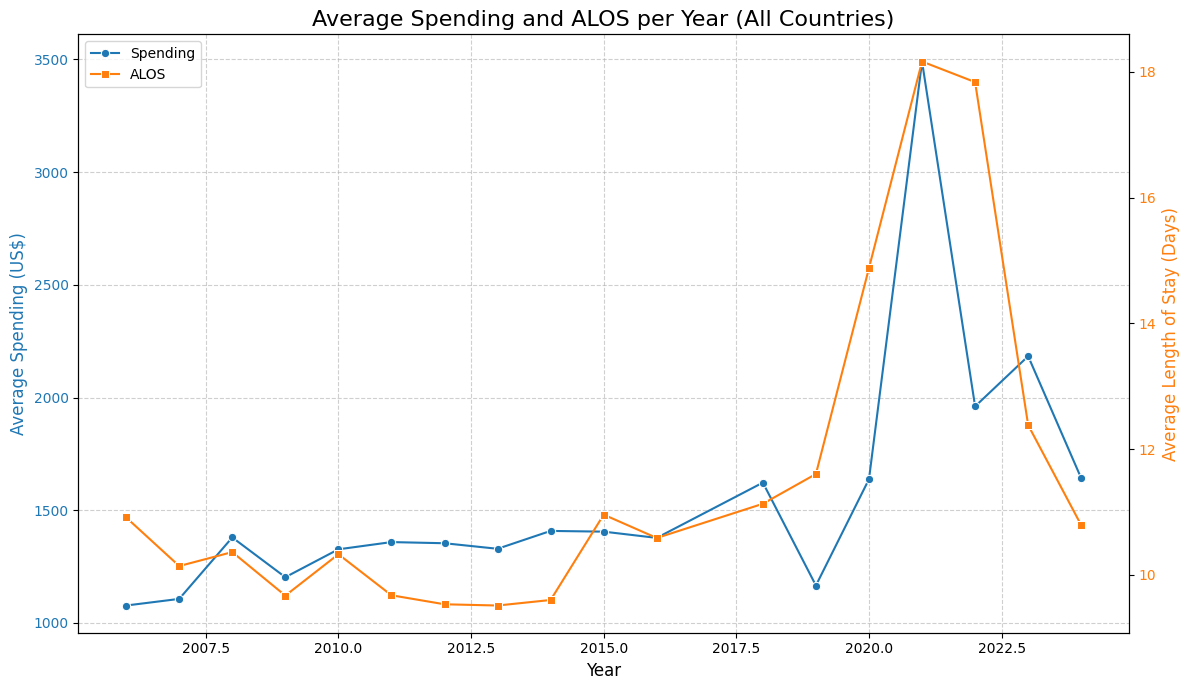

In [31]:
# Aggregate by year
total_by_year = (
    df_clean
    .groupby('year')
    .agg(
        spending=('spending', 'mean'),
        alos=('alos', 'mean')
    )
    .reset_index()
)

fig, ax1 = plt.subplots(figsize=(12, 7))

# Spending line (left axis) — BLUE
sns.lineplot(
    data=total_by_year,
    x='year',
    y='spending',
    marker='o',
    ax=ax1,
    color='tab:blue',
    label='Spending'
)

ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Average Spending (US$)', fontsize=12, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# ALOS line (right axis) — ORANGE
ax2 = ax1.twinx()

sns.lineplot(
    data=total_by_year,
    x='year',
    y='alos',
    marker='s',
    ax=ax2,
    color='tab:orange',
    label='ALOS'
)

ax2.set_ylabel('Average Length of Stay (Days)', fontsize=12, color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Title & grid
plt.title('Average Spending and ALOS per Year (All Countries)', fontsize=16)
ax1.grid(True, linestyle='--', alpha=0.6)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
ax2.get_legend().remove()

plt.tight_layout()
plt.show()

Both **average spending** and **average length of stay** show a quite similar pattern where spline interpolation method will be best fit for normal years (2006-2019 & 2023-2024) since the trends are not linear. However, I will leave the value NaN for the countries do not have records on spending and alos during the pandemic period (2020-2022).

In [32]:
df_imp = df_clean.sort_values(['country', 'year']).copy()

In [33]:
NORMAL_YEARS = df_imp['year'].between(2006, 2019) | df_imp['year'].between(2023, 2024)

df_imp['spending_imp'] = df_imp['spending']
df_imp['alos_imp'] = df_imp['alos']

df_imp.loc[NORMAL_YEARS, 'spending_imp'] = (
    df_imp[NORMAL_YEARS]
    .groupby('country')['spending']
    .transform(lambda x: x.interpolate(method='spline', order=3, limit=2))
    # order=3 (Cubic) --> Smooth and natural curves
    # limit=2 --> max. missing gap is 2 years consecutive
)

df_imp.loc[NORMAL_YEARS, 'alos_imp'] = (
    df_imp[NORMAL_YEARS]
    .groupby('country')['alos']
    .transform(lambda x: x.interpolate(method='spline', order=3, limit=2))
)

/usr/local/lib/python3.12/dist-packages/pandas/core/missing.py:604: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  terp = interpolate.UnivariateSpline(x, y, k=order, **kwargs)


In [34]:
df_imp.loc[df_imp['spending_imp'] < 0, 'spending_imp'] = np.nan # imputation with negative value will be leave as NaN (spline method's consequence)

In [35]:
df_imp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 703 entries, 82 to 1257
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       703 non-null    object 
 1   year          703 non-null    Int64  
 2   visits        703 non-null    float64
 3   spending      591 non-null    float64
 4   alos          664 non-null    float64
 5   spending_imp  630 non-null    float64
 6   alos_imp      701 non-null    float64
dtypes: Int64(1), float64(5), object(1)
memory usage: 44.6+ KB


In [36]:
df_imp[df_imp['country'] == 'Australia']

,country,year,visits,spending,alos,spending_imp,alos_imp
82,Australia,2006,"208,205","1,330",13,"1,330",13
83,Australia,2007,"287,103","1,197",12,"1,197",12
84,Australia,2008,"418,899","1,484",11,"1,484",11
85,Australia,2009,"571,541","1,447",10,"1,447",10
86,Australia,2010,"769,585","1,518",11,"1,518",11
87,Australia,2011,"933,376","1,613",9,"1,613",9
88,Australia,2012,"952,717","1,510",9,"1,510",9
89,Australia,2013,"983,911","1,474",10,"1,474",10
90,Australia,2014,"1,145,576","1,598",9,"1,598",9
91,Australia,2015,"1,090,025","1,617",10,"1,617",10


> For missing imputation values in 'spending' and 'alos' during normal years, there's only Bangladesh, Egypt, and Portugal (see table below). I will leave the NaN values since either it has a long period gap of missing values or it's consider as early period gaps and imputation will be not recommended.

In [37]:
df_imp[(df_imp['spending_imp'].isna()) & ((df_imp['year'].between(2006, 2019)) | (df_imp['year'].between(2023, 2024)))]

,country,year,visits,spending,alos,spending_imp,alos_imp
168,Bangladesh,2023,"9,373",NaN,5,NaN,5
362,Egypt,2023,"16,832",NaN,13,NaN,13
838,Portugal,2006,"10,303",NaN,NaN,NaN,NaN
839,Portugal,2007,"12,222",NaN,NaN,NaN,NaN
840,Portugal,2008,"11,368",NaN,11,NaN,11


In [38]:
df_imp[(df_imp['alos_imp'].isna()) & ((df_imp['year'].between(2006, 2019)) | (df_imp['year'].between(2023, 2024)))]

,country,year,visits,spending,alos,spending_imp,alos_imp
838,Portugal,2006,"10,303",NaN,NaN,NaN,NaN
839,Portugal,2007,"12,222",NaN,NaN,NaN,NaN


## 3.3 Feature Engineering

In [39]:
df_model = df_imp[[
    'country',
    'year',
    'visits',
    'spending_imp',
    'alos_imp'
]].copy()

In [40]:
df_model = df_model.rename(
    columns={
        'spending_imp': 'spending_per_visit',
        'alos_imp': 'alos'
    }
)

**Tourism Value = Total Visitors x Average Spending Per Visit**

In [41]:
df_model['tourism_value'] = df_model['visits'] * df_model['spending_per_visit']

**Spending per Day**

In [42]:
df_model['spending_per_day'] = df_model['spending_per_visit']/df_model['alos']

**GDP and Population**

Adding GDP and Population features will enrich the features and tap the core economic as well as demographic features for each country.

In [43]:
gdp = pd.read_excel('/content/drive/MyDrive/Petalytix/Predicting Tourism Trend/gdp.xlsx', sheet_name='Data')
population = pd.read_excel('/content/drive/MyDrive/Petalytix/Predicting Tourism Trend/population.xlsx', sheet_name='Data')

In [44]:
id_vars_population = ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code']

population_melted = pd.melt(population, id_vars=id_vars_population, var_name='year', value_name='population')
population_melted['year'] = pd.to_numeric(population_melted['year'], errors='coerce').astype(pd.Int64Dtype())
population_melted = population_melted.rename(columns={'Country Name': 'country'})

population_melted.head()

,country,Country Code,Indicator Name,Indicator Code,year,population
0,Aruba,ABW,"Population, total",SP.POP.TOTL,1960,"54,922"
1,Africa Eastern and Southern,AFE,"Population, total",SP.POP.TOTL,1960,"130,075,728"
2,Afghanistan,AFG,"Population, total",SP.POP.TOTL,1960,"9,035,043"
3,Africa Western and Central,AFW,"Population, total",SP.POP.TOTL,1960,"97,630,925"
4,Angola,AGO,"Population, total",SP.POP.TOTL,1960,"5,231,654"


In [45]:
id_vars_gdp = ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code']

gdp_melted = pd.melt(gdp, id_vars=id_vars_gdp, var_name='year', value_name='gdp')
gdp_melted['year'] = pd.to_numeric(gdp_melted['year'], errors='coerce').astype(pd.Int64Dtype())
gdp_melted = gdp_melted.rename(columns={'Country Name': 'country'})

gdp_melted.head()

,country,Country Code,Indicator Name,Indicator Code,year,gdp
0,Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,1960,NaN
1,Africa Eastern and Southern,AFE,GDP (current US$),NY.GDP.MKTP.CD,1960,"24,205,688,712"
2,Afghanistan,AFG,GDP (current US$),NY.GDP.MKTP.CD,1960,NaN
3,Africa Western and Central,AFW,GDP (current US$),NY.GDP.MKTP.CD,1960,"11,904,805,742"
4,Angola,AGO,GDP (current US$),NY.GDP.MKTP.CD,1960,NaN


In [46]:
df_model = pd.merge(df_model, gdp_melted, on=['country', 'year'], how='left')
df_model = pd.merge(df_model, population_melted, on=['country', 'year'], how='left')

In [47]:
df_model = df_model[[
    'country',
    'year',
    'visits',
    'spending_per_visit',
    'alos',
    'spending_per_day',
    'tourism_value',
    'gdp',
    'population'
]]

**GDP per Capita**

In [48]:
df_model['gdp_per_capita'] = df_model['gdp'] / df_model['population']

**Log GDP**

In [49]:
df_model['log_gdp'] = np.log1p(df_model['gdp'])

**Log Population**

In [50]:
df_model['log_population'] = np.log1p(df_model['population'])

**Log GDP per Capita**

In [51]:
df_model['log_gdp_per_capita'] = np.log1p(df_model['gdp_per_capita'])

**Visits per Capita**

In [52]:
df_model['visits_per_capita'] = df_model['visits'] / df_model['population']

**Year Since Start**

In [53]:
df_model['year_since_start'] = df_model['year'] - df_model['year'].min()

**Country Encoding**

In [54]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_model['country_encoded'] = le.fit_transform(df_model['country'])

# 4. Descriptive Analysis

## 4.1 Q1 Which countries generate the highest economic value to Indonesia for tourism sector?

In [101]:
top5 = (
    df_model
    .groupby('country')
    .agg({
        'tourism_value': 'sum',
        'visits': 'sum',
        'spending_per_day': 'mean',
        'alos': 'mean'
    })
    .sort_values('tourism_value', ascending=False)
    .head(5)
)

top5 = top5.rename(columns={
    'tourism_value': 'Total Value (in US$ Bn)',
    'visits': 'Total Visits',
    'spending_per_day': 'Spending per Day (in US$)',
    'alos': 'Avg. Length of Stay (in days)'
})

top5['Total Value (in US$ Bn)'] = top5['Total Value (in US$ Bn)'] / 1e9

top5['Total Value (in US$ Bn)'] = top5['Total Value (in US$ Bn)'].map('{:.1f}'.format)
top5['Avg. Length of Stay (in days)'] = top5['Avg. Length of Stay (in days)'].map('{:.1f}'.format)

top5


,Total Value (in US$ Bn),Total Visits,Spending per Day (in US$),Avg. Length of Stay (in days)
country,,,,
Australia,25.9,"16,625,694",153,10.6
Malaysia,19.5,"27,394,856",177,4.6
China,18.8,"16,554,552",142,12.1
Singapore,17.7,"23,732,193",213,4.1
Japan,8.7,"7,764,274",150,10.7


Since,
- Tourism Value = Total Visitors x Average Spending Per Visit; or
- Tourism Value = Total Visitors x Daily Spending x Avg. Length of Stay

I will be using quadrant analysis to define countries positions on (visitors, spending, and length of stay) to their tourism value.

## 4.2 Tourism Value Visits by Country

In [56]:
from IPython.display import IFrame

report_url = "https://lookerstudio.google.com/embed/reporting/9d91ce5c-9049-4bd0-874d-0d47f072fd84/page/hdVnF"
IFrame(src=report_url, width=800, height=480)


**Top 5 High Visitors – High Tourism Value**
1. Australia
2. China
3. Malaysia
4. Singapore
5. Japan

*Note: High Tourism Value might not linear with their spending behaviour*

## 4.3 Tourism Value vs Length of Stay by Country

In [57]:
report_url = "https://lookerstudio.google.com/embed/reporting/9d91ce5c-9049-4bd0-874d-0d47f072fd84/page/p_il3ofsrn0d"
IFrame(src=report_url, width=800, height=480)

**Top 5 Short-Medium Stay – High Tourism Value**
1. Singapore
2. Malaysia
3. Australia
4. China
5. Japan

*Note: The longer they stay, the lower the tourism value tends to be.*

## 4.4 Tourism Value vs Daily Spending by Country

In [58]:
report_url = "https://lookerstudio.google.com/embed/reporting/9d91ce5c-9049-4bd0-874d-0d47f072fd84/page/p_w8sgaiom0d"
IFrame(src=report_url, width=800, height=480)

**Top 5 High Daily Spending – High Tourism Value**
1. Singapore
2. Malaysia
3. Australia
4. China
5. United States

## 4.5 Daily Spending vs Length of Stay by Country

In [59]:
report_url = "https://lookerstudio.google.com/embed/reporting/9d91ce5c-9049-4bd0-874d-0d47f072fd84/page/p_1ihcf3rn0d"
IFrame(src=report_url, width=800, height=480)

*Note: The longer they stay, the lower daily spending will be. For some countries, they took advantages of cheaper price for long-stay trip during the pandemic*

## 4.6 Tourism Value Trend

In [60]:
report_url = "https://lookerstudio.google.com/embed/reporting/9d91ce5c-9049-4bd0-874d-0d47f072fd84/page/p_xzjrnivn0d"
IFrame(src=report_url, width=800, height=480)

*Note: Tourism value falls during pandemic 2020-2022 and recovers back to the normal trend since 2023.*

## 4.7 Visits Trend

In [61]:
report_url = "https://lookerstudio.google.com/embed/reporting/9d91ce5c-9049-4bd0-874d-0d47f072fd84/page/p_9f1kynpm0d"
IFrame(src=report_url, width=800, height=480)

*Note: Inbound visits before pandemic reached the peak at ~13,5 millions visits in 2019 which Malaysia and China become the largest contributors (40%+ altogether).*

## 4.8 Daily Spending Trend

In [62]:
report_url = "https://lookerstudio.google.com/embed/reporting/9d91ce5c-9049-4bd0-874d-0d47f072fd84/page/p_stvnk5pm0d"
IFrame(src=report_url, width=800, height=480)

*Note: Spending behaviour trend of foreign visitors for tourism is increasing overtime where during pandemic they spent more.*

## 4.9 Avg. Length of Stay Trend

In [63]:
report_url = "https://lookerstudio.google.com/embed/reporting/9d91ce5c-9049-4bd0-874d-0d47f072fd84/page/p_wn68m5pm0d"
IFrame(src=report_url, width=800, height=480)

*Note: Foreign visitors had a longer stay for every visit overtime. Especially during pandemic, they stayed almost 3 weeks in average.*

# 5. Modeling

## 5.1 Feature Selection

**Country Encoded Mapping**

In [64]:
country_mapping = pd.DataFrame({
    'country': le.classes_,
    'encoded_value': range(len(le.classes_))
})

In [65]:
df_m = df_model.dropna(subset=['tourism_value']).copy()
df_m = df_m[~((df_m['year'].isin([2020, 2021, 2022])))]
df_m['year'] = df_m['year'].astype('float64')

In [66]:
print(f"Total clean records (exc. pandemic years): {len(df_m['country'])} rows")

Total clean records (exc. pandemic years): 587 rows


**Select Target and Features**

In [67]:
features = [
    'gdp',
    'population',
    'gdp_per_capita',
    'log_gdp',
    'log_population',
    'log_gdp_per_capita',
    'year',
    'year_since_start',
    'country_encoded'
    ]

target = 'tourism_value'

df_base = df_m[features + [target]].dropna()

X = df_base[features]
y = df_base[target]

## 5.2 Train-test Split

In [68]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=52,
    stratify=df_m.loc[X.index, 'country_encoded']
)

test_countries = df_m.loc[y_test.index, 'country'].values

In [69]:
print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Train set: 469 samples
Test set: 118 samples


**Feature Scaling**

In [70]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## 5.3 Models Training and Evaluation

In [71]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=100.0, random_state=52),
    'Lasso Regression': Lasso(alpha=1000.0, random_state=52),
    'Elastic Net Regression': ElasticNet(alpha=1000.0, l1_ratio=0.5, random_state=52),
    'Decision Tree Regression': DecisionTreeRegressor(max_depth=10, random_state=52),
    'Random Forest Regression': RandomForestRegressor(n_estimators=200, max_depth=15, random_state=52, n_jobs=-1),
    'Gradient Boosting Regression': GradientBoostingRegressor(n_estimators=200, max_depth=7, learning_rate=0.1, random_state=52)
}

In [72]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score

results = []
trained_models = {}
predictions_dict = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")

    # Train model
    model.fit(X_train_scaled, y_train)
    trained_models[model_name] = model

    # Prediction
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    predictions_dict[model_name] = {
        'train': y_train_pred,
        'test': y_test_pred
    }

    # Metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    # MAPE
    train_mape = np.mean(np.abs((y_train - y_train_pred) / (y_train + 1e-10))) * 100
    test_mape = np.mean(np.abs((y_test - y_test_pred) / (y_test + 1e-10))) * 100

    # Cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2', n_jobs=-1)

    results.append({
        'Model': model_name,
        'Train R²': train_r2,
        'Test R²': test_r2,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Train MAE': train_mae,
        'Test MAE': test_mae,
        'Train MAPE': train_mape,
        'Test MAPE': test_mape,
        'CV R² (mean)': cv_scores.mean(),
        'CV R² (std)': cv_scores.std()
    })

    print(f"  Test R²: {test_r2:.4f}")
    print(f"  Test RMSE: ${test_rmse:,.0f}")
    print(f"  Test MAE: ${test_mae:,.0f}")
    print(f"  CV R² (mean ± std): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Training Linear Regression...
  Test R²: 0.1387
  Test RMSE: $349,516,751
  Test MAE: $229,799,307
  CV R² (mean ± std): 0.1115 ± 0.1921

Training Ridge Regression...
  Test R²: 0.1548
  Test RMSE: $346,243,638
  Test MAE: $227,659,661
  CV R² (mean ± std): 0.1251 ± 0.1560

Training Lasso Regression...
  Test R²: 0.1424
  Test RMSE: $348,775,554
  Test MAE: $227,994,068
  CV R² (mean ± std): 0.1129 ± 0.1939

Training Elastic Net Regression...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.396e+16, tolerance: 9.334e+15
  model = cd_fast.enet_coordinate_descent(


  Test R²: 0.0019
  Test RMSE: $376,263,932
  Test MAE: $254,040,853
  CV R² (mean ± std): -0.0256 ± 0.0277

Training Decision Tree Regression...
  Test R²: 0.8893
  Test RMSE: $125,300,276
  Test MAE: $70,489,230
  CV R² (mean ± std): 0.8584 ± 0.0411

Training Random Forest Regression...
  Test R²: 0.8304
  Test RMSE: $155,092,554
  Test MAE: $70,894,393
  CV R² (mean ± std): 0.8879 ± 0.0359

Training Gradient Boosting Regression...
  Test R²: 0.9190
  Test RMSE: $107,191,119
  Test MAE: $57,234,238
  CV R² (mean ± std): 0.8950 ± 0.0205


In [73]:
results_df = pd.DataFrame(results)

# 6. Evaluation (Business Interpretation)

## 6.1 Selecting The Best Model

In [74]:
best_model_idx = results_df['Test R²'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']
best_test_r2 = results_df.loc[best_model_idx, 'Test R²']
best_test_mae = results_df.loc[best_model_idx, 'Test MAE']
best_test_rmse = results_df.loc[best_model_idx, 'Test RMSE']

print(f"\nBest Model: {best_model_name}")
print(f"  - Test R² = {best_test_r2:.4f} ({best_test_r2*100:.2f}% variance explained)")
print(f"  - Test MAE = ${best_test_mae:,.0f}")
print(f"  - Test RMSE = ${best_test_rmse:,.0f}")


Best Model: Gradient Boosting Regression
  - Test R² = 0.9190 (91.90% variance explained)
  - Test MAE = $57,234,238
  - Test RMSE = $107,191,119


## 6.2 Q2 What factors explain why some countries contribute higher tourism value than others?

**Feature Importance Analysis**

In [75]:
feature_importance_dict = {}

for model_name in ['Decision Tree Regression', 'Random Forest Regression', 'Gradient Boosting Regression']:
    model = trained_models[model_name]
    importances = model.feature_importances_

    # Create DataFrame and apply formatting for 'Importance'
    df_importance = pd.DataFrame({
        'Feature': features,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    # Format the 'Importance' column to 3 decimal places
    df_importance['Importance'] = df_importance['Importance'].map('{:.3f}'.format)

    feature_importance_dict[model_name] = df_importance

    print(f"\n{model_name} - Top 5 Important Features:")
    print(feature_importance_dict[model_name].head().to_string(index=False))



Decision Tree Regression - Top 5 Important Features:
        Feature Importance
country_encoded      0.421
 log_population      0.275
     population      0.103
        log_gdp      0.067
            gdp      0.047

Random Forest Regression - Top 5 Important Features:
        Feature Importance
country_encoded      0.463
 log_population      0.168
     population      0.137
        log_gdp      0.053
            gdp      0.051

Gradient Boosting Regression - Top 5 Important Features:
        Feature Importance
country_encoded      0.442
 log_population      0.166
     population      0.128
            gdp      0.072
        log_gdp      0.049


In [109]:
df_model[df_model['country'].isin(['Malaysia', 'Germany'])].groupby('country').agg({
    'tourism_value': 'sum',
    'visits': 'sum',
    'spending_per_day': 'mean',
    'alos': 'mean',
})

,tourism_value,visits,spending_per_day,alos
country,,,,
Germany,"5,528,140,735","3,291,965",114,16
Malaysia,"19,473,281,990","27,394,856",177,5


**Top 3 Most Important Features (74%):**
1. Country Identity (44%): Each country has unique tourism characteristics. This may be due to: *geographic location, visa policies, cultural fit, tourism brand, access (flights frequency, price, etc.) and so on*
2. Population Size (17%): Market size drives tourism potential
3. Population (13%): Raw market size (more people = more tourists)

*Note: Country Identity > Demographic and Economic factors combined is a sign that proximity, cultural ties, and ease of travel matter most*

*For example, Malaysia (moderate GDP/capita) generate more value than Germany (high GDP/capita)*

In [76]:
print("\n\nLinear Models - Feature Coefficients (Top 5 by absolute value):")
print("-"*60)

for model_name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression']:
    model = trained_models[model_name]
    coef_df = pd.DataFrame({
        'Feature': features,
        'Coefficient': model.coef_
    }).sort_values('Coefficient', key=abs, ascending=False)

    print(f"\n{model_name}:")
    print(coef_df.head().to_string(index=False))



Linear Models - Feature Coefficients (Top 5 by absolute value):
------------------------------------------------------------

Linear Regression:
           Feature      Coefficient
    log_population -285,708,537,791
           log_gdp  244,060,060,458
log_gdp_per_capita -223,288,851,954
        population       86,334,549
   country_encoded      -68,639,876

Ridge Regression:
           Feature  Coefficient
        population   66,059,156
           log_gdp   59,405,579
               gdp   59,386,823
   country_encoded  -53,245,688
log_gdp_per_capita   51,642,475

Lasso Regression:
       Feature  Coefficient
       log_gdp  125,098,746
    population   89,751,565
          year   88,643,659
log_population  -76,062,254
           gdp   64,822,434


**Coefficients Interpreation (Ridge Regression):**
1. Larger and wealthier country generate more tourism value
2. Linear models capture less variance since the relationships are non-linear

## 6.3 Prediction Analysis

In [77]:
best_model = trained_models[best_model_name]
y_test_pred_best = best_model.predict(X_test_scaled)

# Residuals
residuals = y_test - y_test_pred_best

print(f"\nResidual Analysis ({best_model_name}):")
print(f"  Mean Residual: ${residuals.mean():,.0f}")
print(f"  Std Residual: ${residuals.std():,.0f}")
print(f"  Min Residual: ${residuals.min():,.0f}")
print(f"  Max Residual: ${residuals.max():,.0f}")

# Predictions by country
predictions_df = pd.DataFrame({
    'Country': test_countries,
    'Actual': y_test,
    'Predicted': y_test_pred_best,
    'Residual': residuals,
    'Absolute_Error': np.abs(residuals),
    'Percentage_Error': (np.abs(residuals) / (y_test + 1e-10)) * 100
})

predictions_by_country = predictions_df.groupby('Country').agg({
    'Actual': 'mean',
    'Predicted': 'mean',
    'Absolute_Error': 'mean',
    'Percentage_Error': 'mean'
}).round(2)

print(f"\n\nPrediction Performance by Country (Top 10 by Absolute Error):")
print("----------------------------------------------------------------------------")
print(predictions_by_country.sort_values('Absolute_Error', ascending=False).head(10).to_string())


Residual Analysis (Gradient Boosting Regression):
  Mean Residual: $-7,467,678
  Std Residual: $107,386,674
  Min Residual: $-452,111,847
  Max Residual: $359,826,834


Prediction Performance by Country (Top 10 by Absolute Error):
----------------------------------------------------------------------------
                      Actual     Predicted  Absolute_Error  Percentage_Error
Country                                                                     
Australia        967,206,339 1,160,752,866     366,711,227                96
South America     57,990,657   270,775,990     212,785,333               480
Singapore      1,220,356,631 1,076,200,713     197,511,949                16
Malaysia       1,017,860,983 1,105,818,429     176,093,105                16
India            912,870,978   754,869,490     158,001,487                17
Saudi Arabia     285,180,224   380,551,796     149,219,533                63
China            719,138,676   710,196,292     106,011,772                2

**Prediction Errors Analysis:**
1. Large absolute error in high-value market but reasonable percentage errors
2. High percentage error in small market
3. Best prediction for Japan (11%), the demographic and economic features align well with the tourism behaviour

# 7. Deploy (Visualizations)

## 7.1 Models Comparison, Feature Importance, and Predictions

/tmp/ipython-input-1385935378.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_yticklabels(results_df['Model'], fontsize=8)


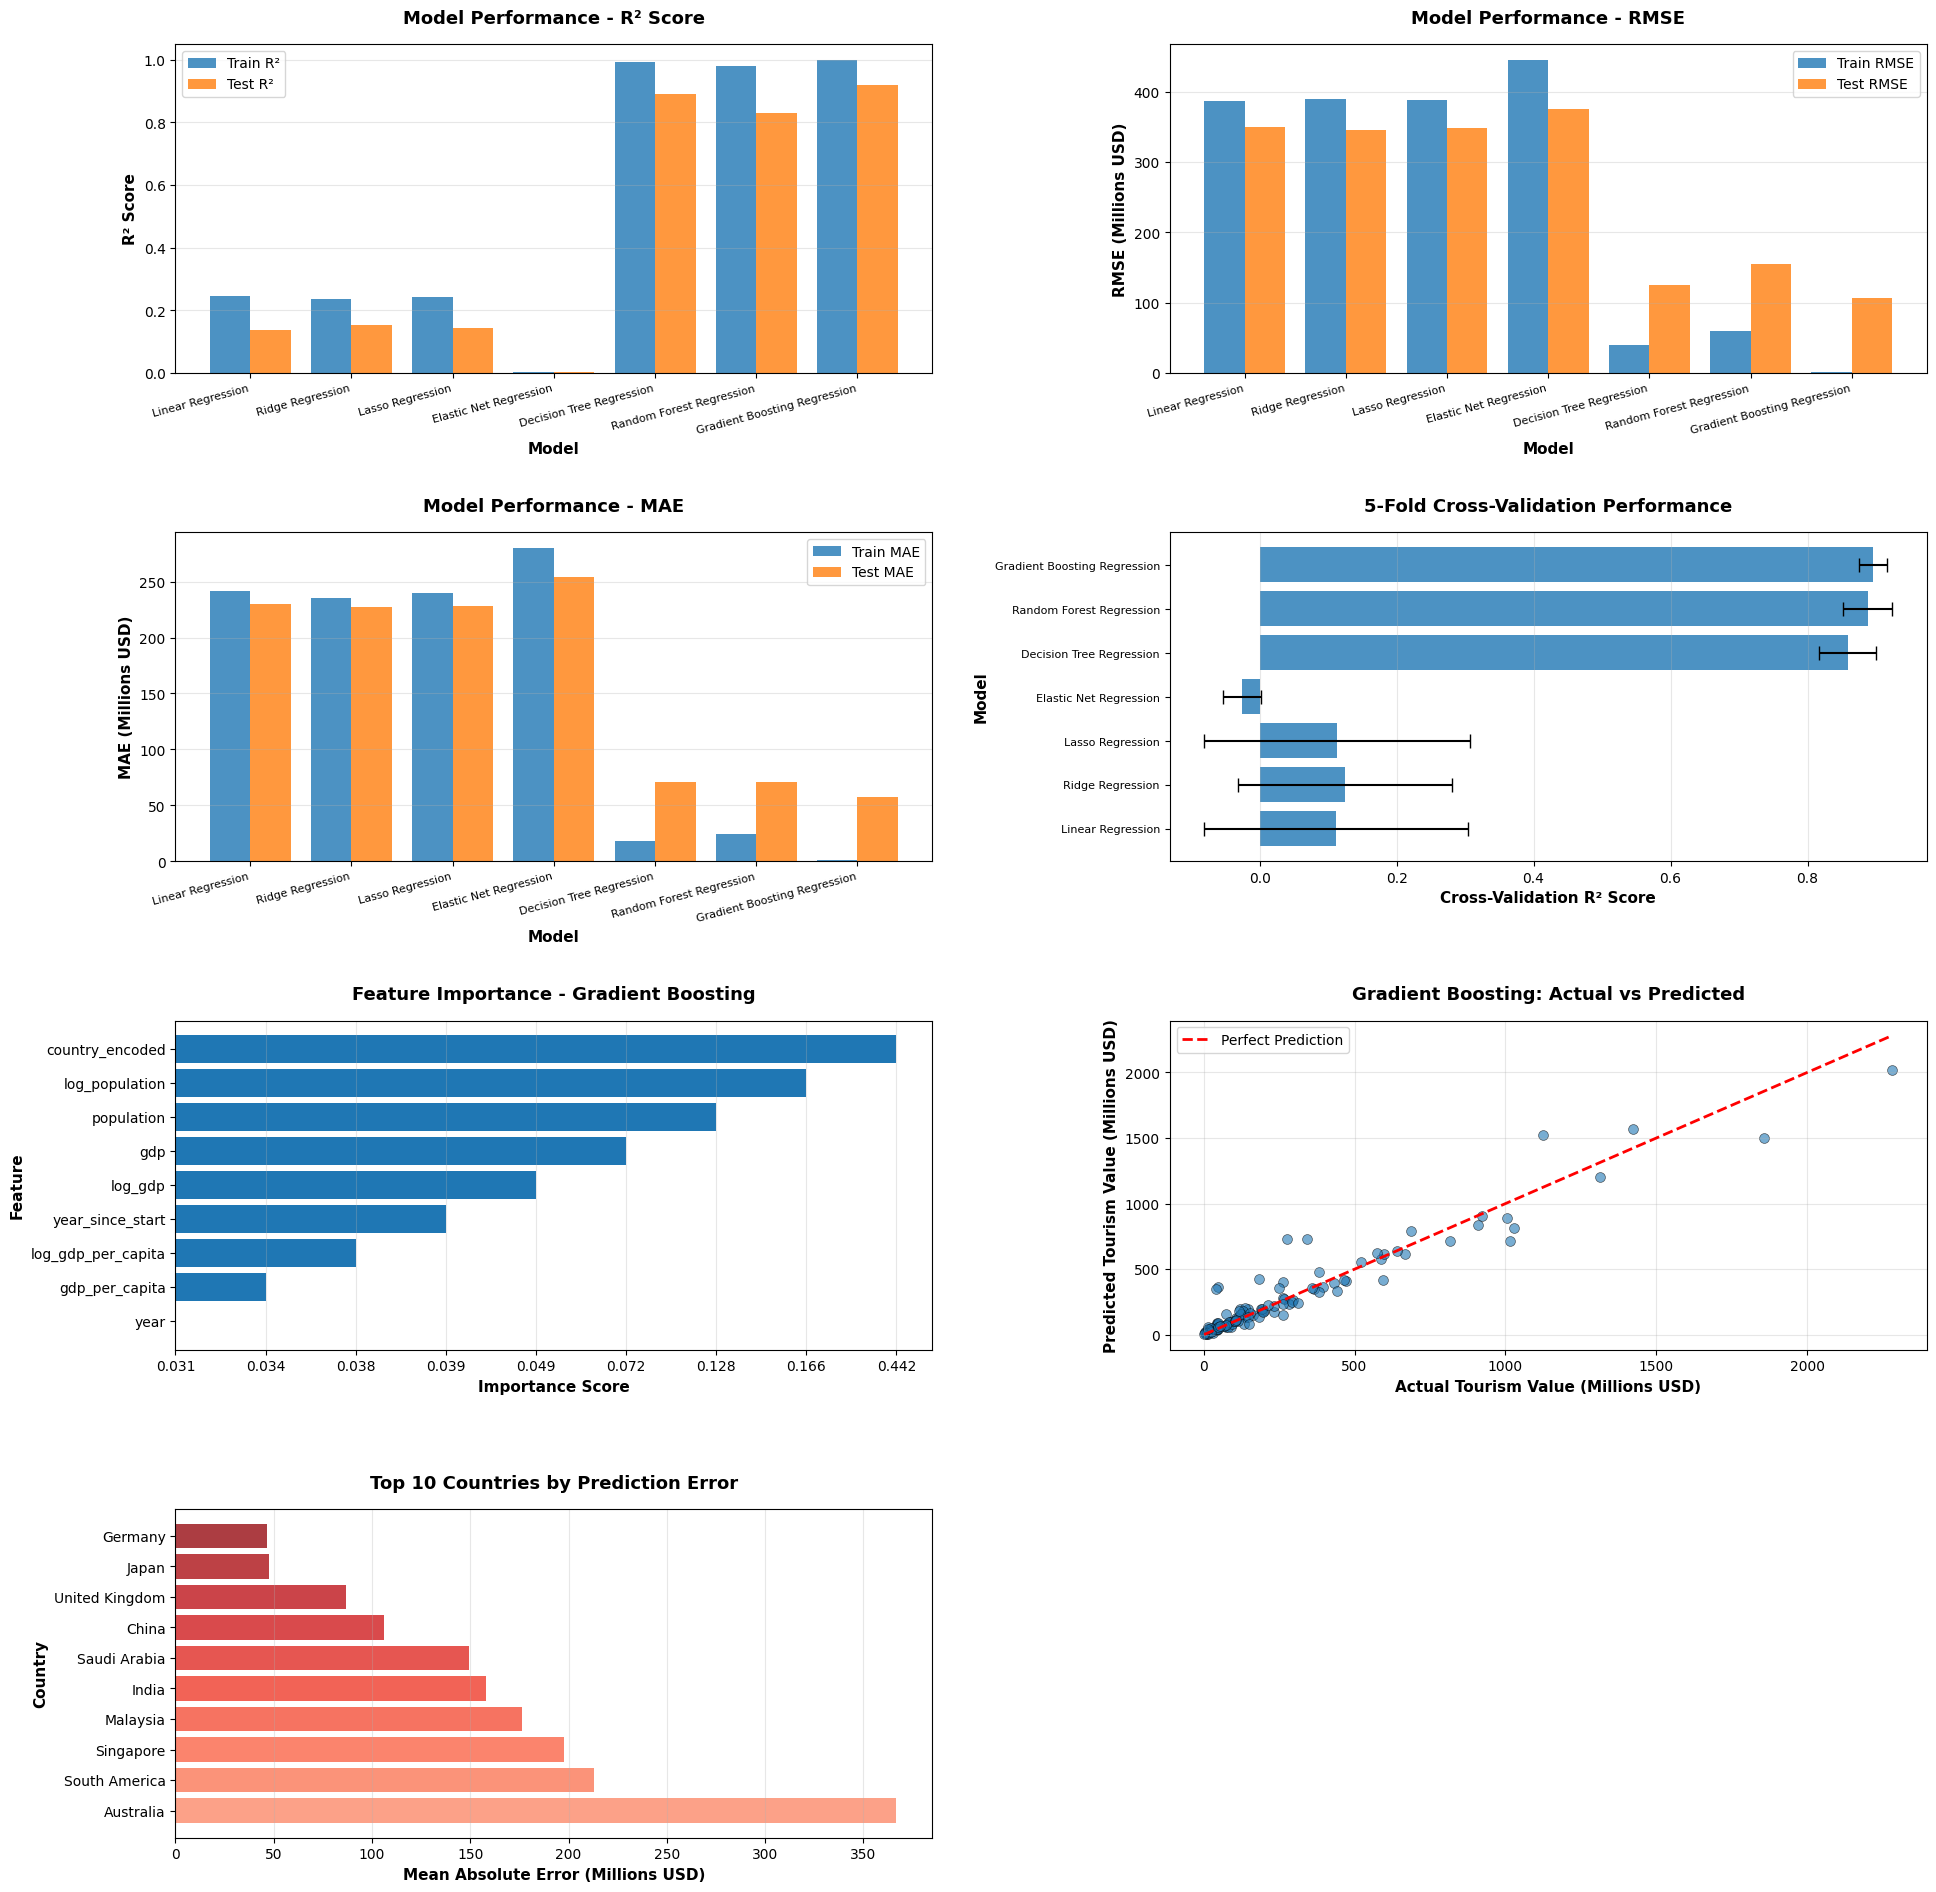

In [78]:
fig = plt.figure(figsize=(20, 24))

ax1 = plt.subplot(5, 2, 1)
x_pos = np.arange(len(results_df))
ax1.bar(x_pos - 0.2, results_df['Train R²'], width=0.4, label='Train R²', alpha=0.8)
ax1.bar(x_pos + 0.2, results_df['Test R²'], width=0.4, label='Test R²', alpha=0.8)
ax1.set_xlabel('Model', fontsize=11, fontweight='bold')
ax1.set_ylabel('R² Score', fontsize=11, fontweight='bold')
ax1.set_title('Model Performance - R² Score', fontsize=13, fontweight='bold', pad=15)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(results_df['Model'], fontsize=8, rotation=15, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

ax2 = plt.subplot(5, 2, 2)
x_pos = np.arange(len(results_df))
ax2.bar(x_pos - 0.2, results_df['Train RMSE']/1e6, width=0.4, label='Train RMSE', alpha=0.8)
ax2.bar(x_pos + 0.2, results_df['Test RMSE']/1e6, width=0.4, label='Test RMSE', alpha=0.8)
ax2.set_xlabel('Model', fontsize=11, fontweight='bold')
ax2.set_ylabel('RMSE (Millions USD)', fontsize=11, fontweight='bold')
ax2.set_title('Model Performance - RMSE', fontsize=13, fontweight='bold', pad=15)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(results_df['Model'], fontsize=8, rotation=15, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

ax3 = plt.subplot(5, 2, 3)
x_pos = np.arange(len(results_df))
ax3.bar(x_pos - 0.2, results_df['Train MAE']/1e6, width=0.4, label='Train MAE', alpha=0.8)
ax3.bar(x_pos + 0.2, results_df['Test MAE']/1e6, width=0.4, label='Test MAE', alpha=0.8)
ax3.set_xlabel('Model', fontsize=11, fontweight='bold')
ax3.set_ylabel('MAE (Millions USD)', fontsize=11, fontweight='bold')
ax3.set_title('Model Performance - MAE', fontsize=13, fontweight='bold', pad=15)
ax3.set_xticks(x_pos)
ax3.set_xticklabels(results_df['Model'], fontsize=8, rotation=15, ha='right')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

ax4 = plt.subplot(5, 2, 4)
ax4.barh(results_df['Model'], results_df['CV R² (mean)'],
         xerr=results_df['CV R² (std)'], alpha=0.8, capsize=5)
ax4.set_xlabel('Cross-Validation R² Score', fontsize=11, fontweight='bold')
ax4.set_ylabel('Model', fontsize=11, fontweight='bold')
ax4.set_title('5-Fold Cross-Validation Performance', fontsize=13, fontweight='bold', pad=15)
ax4.set_yticklabels(results_df['Model'], fontsize=8)
ax4.grid(axis='x', alpha=0.3)

ax5 = plt.subplot(5, 2, 5)
fi_gb = feature_importance_dict['Gradient Boosting Regression']
fi_gb = fi_gb.sort_values('Importance', ascending=True)
ax5.barh(fi_gb['Feature'], fi_gb['Importance'])
ax5.set_xlim(left=0)
ax5.set_xlabel('Importance Score', fontsize=11, fontweight='bold')
ax5.set_ylabel('Feature', fontsize=11, fontweight='bold')
ax5.set_title('Feature Importance - Gradient Boosting', fontsize=13, fontweight='bold', pad=15)
ax5.grid(axis='x', alpha=0.3)

ax6 = plt.subplot(5, 2, 6)
gb_test_pred = predictions_dict['Gradient Boosting Regression']['test']
ax6.scatter(y_test/1e6, gb_test_pred/1e6, alpha=0.6, s=50, edgecolors='k', linewidth=0.5)
min_val = min(y_test.min(), gb_test_pred.min()) / 1e6
max_val = max(y_test.max(), gb_test_pred.max()) / 1e6
ax6.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
ax6.set_xlabel('Actual Tourism Value (Millions USD)', fontsize=11, fontweight='bold')
ax6.set_ylabel('Predicted Tourism Value (Millions USD)', fontsize=11, fontweight='bold')
ax6.set_title('Gradient Boosting: Actual vs Predicted', fontsize=13, fontweight='bold', pad=15)
ax6.legend()
ax6.grid(alpha=0.3)

ax7 = plt.subplot(5, 2, 7)
country_perf = predictions_df.groupby('Country').agg({
    'Absolute_Error': 'mean'
}).sort_values('Absolute_Error', ascending=False).head(10)
colors_bar = plt.cm.Reds(np.linspace(0.4, 0.9, len(country_perf)))
ax7.barh(country_perf.index, country_perf['Absolute_Error']/1e6, color=colors_bar, alpha=0.8)
ax7.set_xlabel('Mean Absolute Error (Millions USD)', fontsize=11, fontweight='bold')
ax7.set_ylabel('Country', fontsize=11, fontweight='bold')
ax7.set_title('Top 10 Countries by Prediction Error', fontsize=13, fontweight='bold', pad=15)
ax7.grid(axis='x', alpha=0.3)

plt.tight_layout(pad=3.0)